This kernel is froked from [Intro - chest xray, DICOM, viz, U-nets - full data](https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data) <br/>
and revised from my old kernel [silver medalImage Pre-processing for Wild Images](https://www.kaggle.com/seriousran/image-pre-processing-for-wild-images).

I'm not sure if this pre-processing is helpful or not, however, looks clearer.
Have a look "before & after"

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import glob

import pydicom

print(os.listdir("../input/siim-acr-pneumothorax-segmentation"))
print()
print(os.listdir("../input/siim-acr-pneumothorax-segmentation/sample images"))
# Any results you write to the current directory are saved as output.

from matplotlib import cm
from matplotlib import pyplot as plt

import tensorflow as tf

from tqdm import tqdm_notebook

import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask

import cv2

['sample_submission.csv', 'sample images', 'download_images.py', 'mask_functions.py']

['1.2.276.0.7230010.3.1.4.8323329.12743.1517875241.599591.dcm', '1.2.276.0.7230010.3.1.4.8323329.4440.1517875182.865105.dcm', 'train-rle-sample.csv', '1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709.dcm', '1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.dcm', '1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm', '1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420.dcm', '1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.dcm', '1.2.276.0.7230010.3.1.4.8323329.4982.1517875185.837576.dcm', '1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290.dcm', '1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.dcm']


In [2]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


# Before

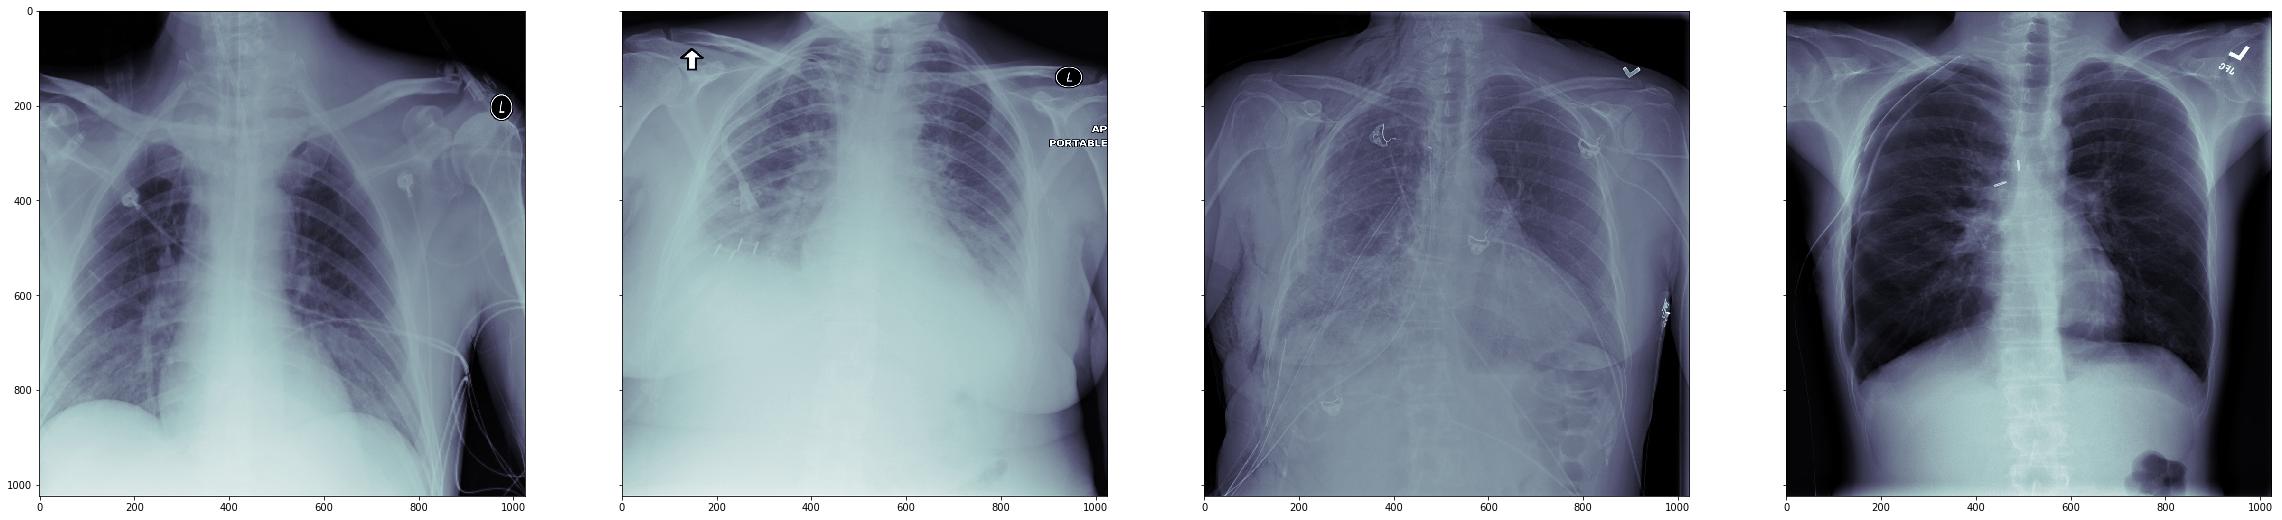

In [3]:
start = 5   # Starting index of images
num_img = 4 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)


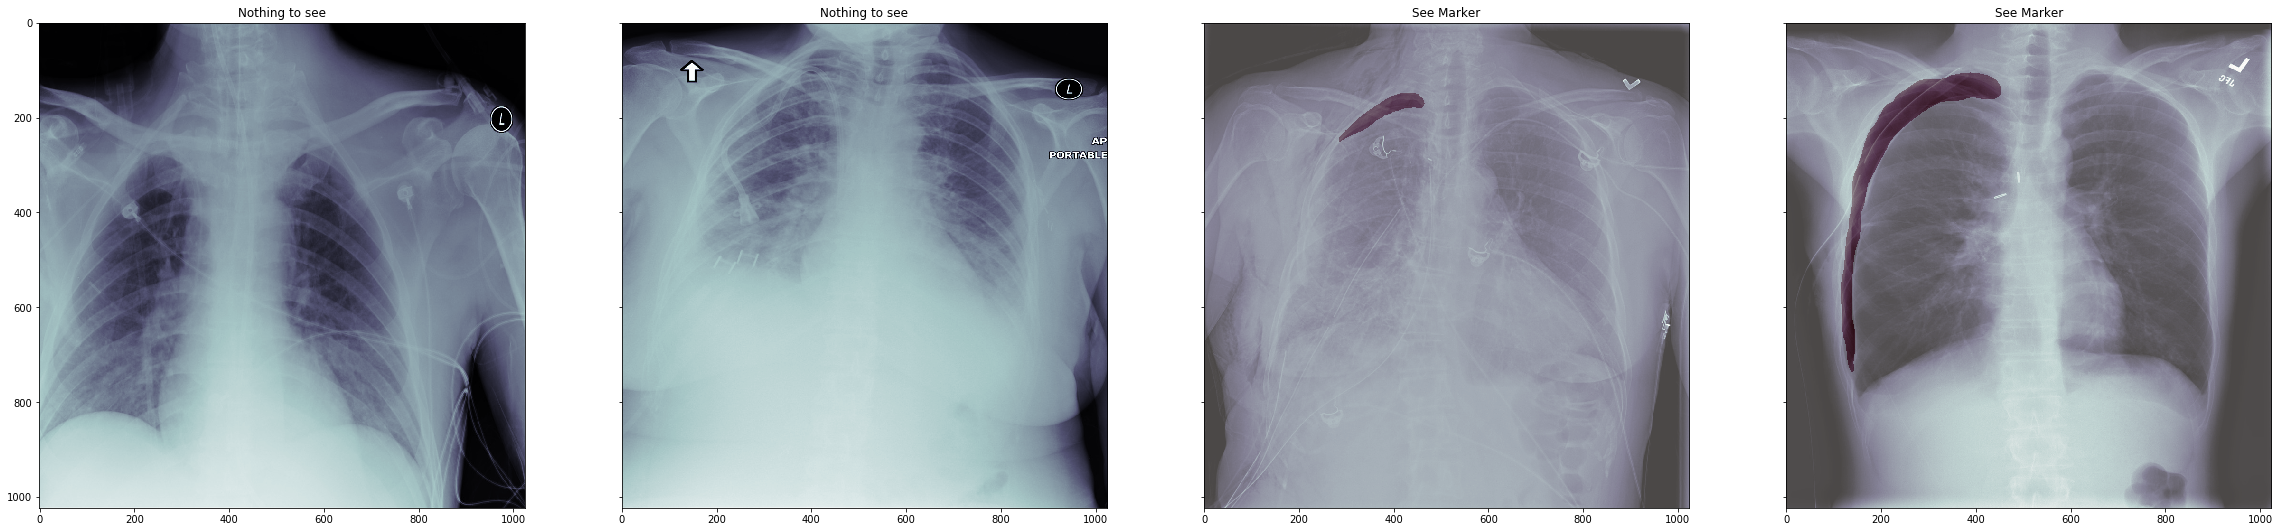

In [4]:
df = pd.read_csv('../input/siim-acr-pneumothorax-segmentation/sample images/train-rle-sample.csv', header=None, index_col=0)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #print(file_path.split('/')[-1][:-4])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
        mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.3, cmap="Reds")
    else:
        ax[q].set_title('Nothing to see')


<br/>
# After
## CLAHE(Contrast Limited Adaptive Histogram Equalization)
![](http://)ref: https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

In [5]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))

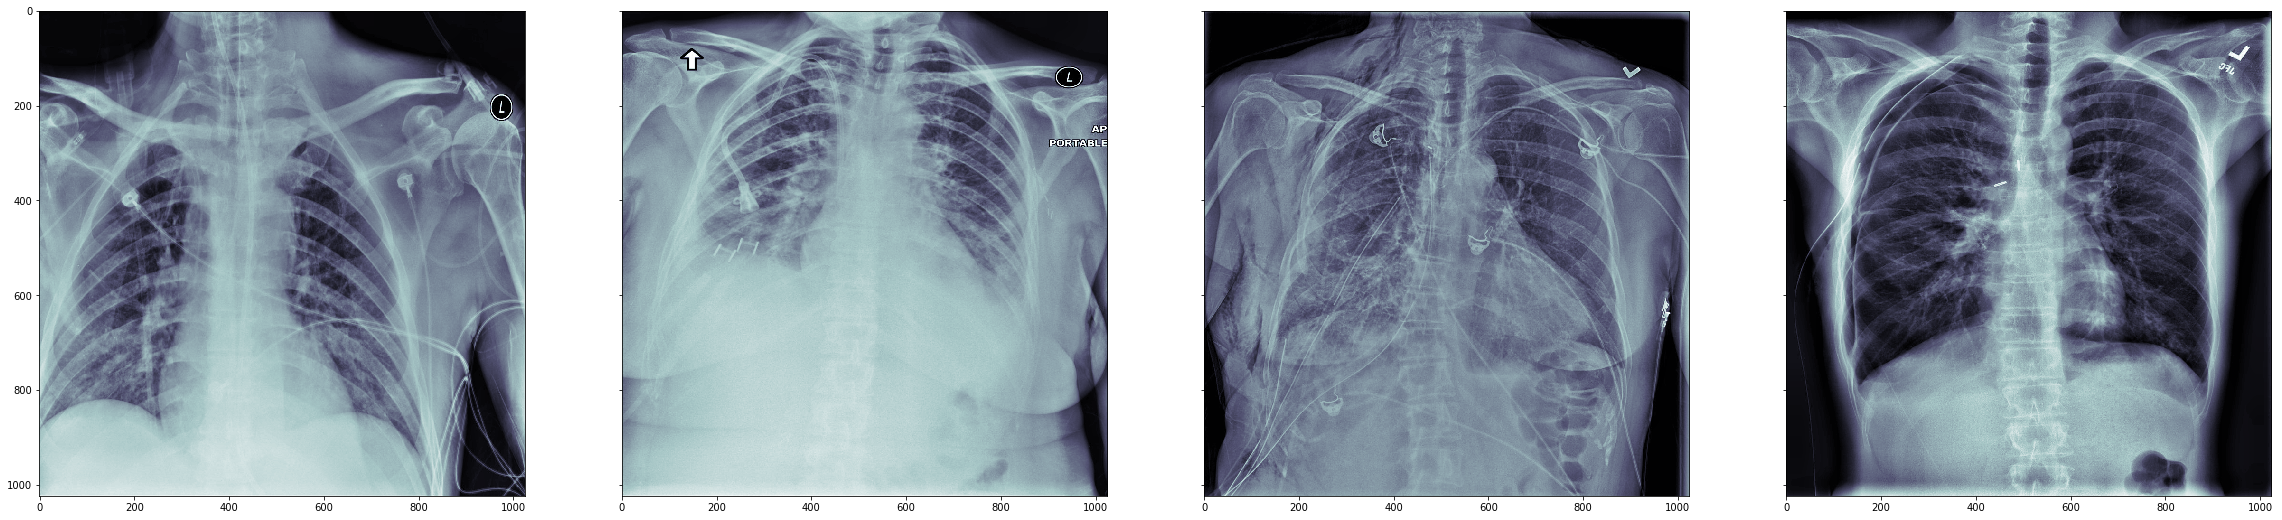

In [6]:
start = 5   # Starting index of images
num_img = 4 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)

    src_img = dataset.pixel_array
    img_clahe = clahe.apply(src_img)
    
    ax[q].imshow(img_clahe, cmap=plt.cm.bone)

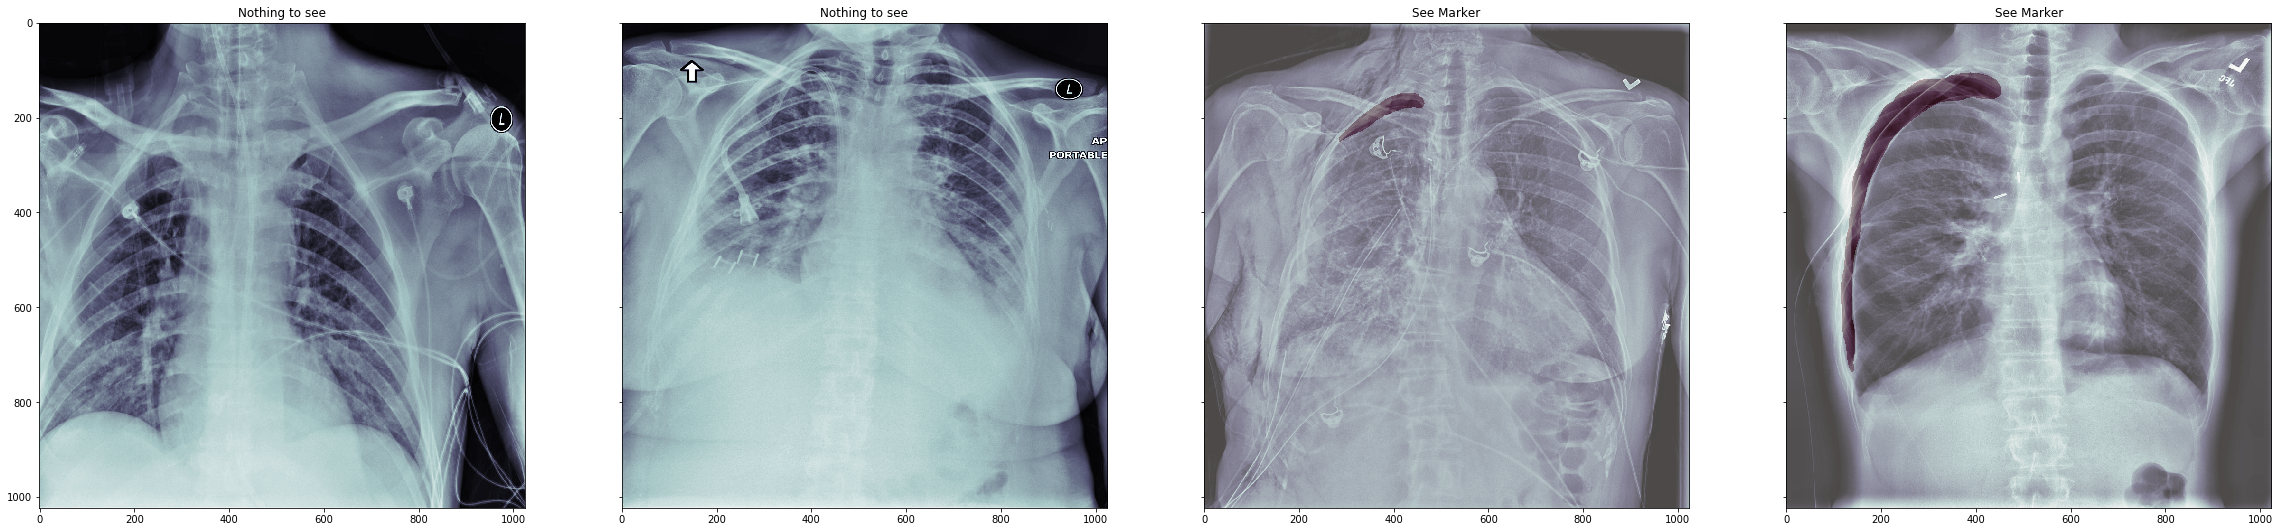

In [7]:
df = pd.read_csv('../input/siim-acr-pneumothorax-segmentation/sample images/train-rle-sample.csv', header=None, index_col=0)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    src_img = dataset.pixel_array
    img_clahe = clahe.apply(src_img)
    ax[q].imshow(img_clahe, cmap=plt.cm.bone)
    if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
        mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.3, cmap="Reds")
    else:
        ax[q].set_title('Nothing to see')
